# 结合pandas和matplotlib制作数据科学GUI工具


python的一大作用就是做数据分析,如果使用tkinter构建数据科学工具,那么难免会使用到表格和图表,第三方工具[pandastable](https://github.com/dmnfarrell/pandastable)提供了对表格和数据图片的支持.多数时候这个工具可以满足数据分析的一般需求.



## pandastable

这个包的使用方式和标准库基本一样.

`TableModel`类似tkinter中的`XxxxVar`,用于维护表格数据,而`TableCanvas`就是控件类了.

### TableModel

`TableModel`初始化可以使用`TableModel(dataframe=None, rows=20, columns=5)`如果初始化的时候已经有pandas的dataframe对象,那么后两个参数就没必要写上,同时`TableModel`的实例中`dataframe`也是可以访问的,可以对其直接操作以修改其内容.其他的接口可以看它的[api文档](http://pandastable.readthedocs.io/en/latest/pandastable.html#module-pandastable.data)


### Table

`Table`和一般的控件使用方法差不多,都需要以个父级控件作为初始化的参数,它的设置中多出了一个`model`参数用于指定`TableModel`的实例.同时`Table`的实例中也有`model`对象可以直接访问到对应的model实例.

其他的设置项包括:

+ `dataframe=None`指定要显示的dataframe
+ `showtoolbar=False`是否显示工具条
+ `showstatusbar=False`是否显示状态条

`TableCanvas`常用的方法有:

+ `table.show()`将图表渲染到gui
+ `table.updateModel(model)`更新图表数据
+ `table.redraw()`重新画图表
+ `table.importCSV(path)`从csv中导入数据
+ `table.columncolors['mycol'] = '#dcf1fc'`为指定列设置显示颜色
+ `table.setRowColors(rows, color)`为指定行设置颜色
+ `table.clearFormatting()` 清空格式设置
+ `table.sortTable(columnIndex=None, ascending=1, index=False)`排序表格
+ `table.showPlotViewer(parent=None, layout='horizontal')`开启作图页面

其他的接口可以查看接口文档<http://pandastable.readthedocs.io/en/latest/pandastable.html#module-pandastable.core>
![](source/table_canvas.png)

In [28]:
%%writefile src/table_canvas.py
from tkinter import Tk,Frame
from pandastable import Table, TableModel

root = Tk()
f = Frame(root)
f.pack(fill="both",expand=1)
model = TableModel.getSampleData()
table = Table(f, dataframe=model,showtoolbar=True, showstatusbar=True)
table.show()
table.showPlotViewer()
#table.showPlot()

root.mainloop()

Overwriting src/table_canvas.py


In [29]:
%exec_py src/table_canvas.py

## 直接使用matplotlib作图

上面的`pandastable`工具更多的是通用的静态数据可视化工具,但更多的时候可能还是需要使用`matplotlib`直接作图.

要让`matplotlib`绘制的图片可以在tk中展示需要使用组件`matplotlib.backends.backend_tkagg.FigureCanvasTkAgg`和`matplotlib.backends.backend_tkagg.NavigationToolbar2TkAgg`

+ `FigureCanvasTkAgg(f, master=root)`是绘图的画板(注意不是tk组件),第一位是要绘制的图片对象`matplotlib.figure.Figure`的实例,使用`.show()`方法展示渲染出来的图,`.get_tk_widget()`用于从这个绘图板上获取tk的对应组件.

+ `NavigationToolbar2TkAgg(canvas, root)`是画板的工具栏,第一位是`FigureCanvasTkAgg`组件的实例,第二位是父组件,`.update()`方法用于更新组件的状态

同时需要在绘图时指定好backend:`matplotlib.use('TkAgg')`

我们来绘制一个k线图


![](source/matplotlib_draw.png)

In [30]:
%matplotlib inline

In [34]:
import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.finance as mpf
from matplotlib.pylab import date2num
import tushare as ts

In [35]:
wdyx = ts.get_k_data('002739','2017-01-01')
wdyx.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 120 entries, 0 to 119
Data columns (total 7 columns):
date      120 non-null object
open      120 non-null float64
close     120 non-null float64
high      120 non-null float64
low       120 non-null float64
volume    120 non-null float64
code      120 non-null object
dtypes: float64(5), object(2)
memory usage: 7.5+ KB


In [36]:
wdyx[:3]

date    open   close    high     low    volume    code
0  2017-01-03  54.010  54.070  54.110  53.711   30518.0  002739
1  2017-01-04  54.090  56.691  56.771  53.831  103953.0  002739
2  2017-01-05  56.302  56.591  57.080  55.924   65414.0  002739

In [37]:
def date_to_num(dates):
    num_time = []
    for date in dates:
        date_time = datetime.datetime.strptime(date,'%Y-%m-%d')
        num_date = date2num(date_time)
        num_time.append(num_date)
    return num_time

In [38]:
mat_wdyx = wdyx.as_matrix()
num_time = date_to_num(mat_wdyx[:,0])
mat_wdyx[:,0] = num_time

In [39]:
mat_wdyx[:3]

array([[736332.0, 54.01, 54.07, 54.11, 53.711, 30518.0, '002739'],
       [736333.0, 54.09, 56.691, 56.771, 53.831, 103953.0, '002739'],
       [736334.0, 56.302, 56.591, 57.08, 55.924, 65414.0, '002739']], dtype=object)

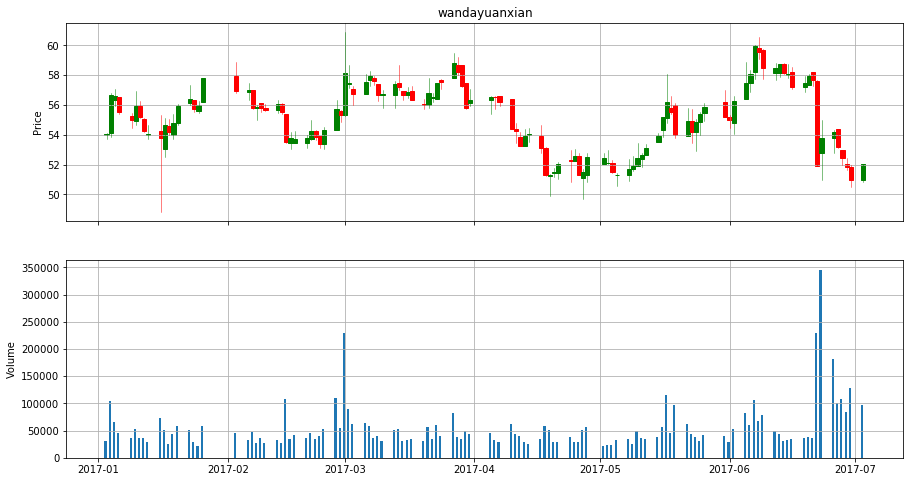

In [40]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(15,8))
mpf.candlestick_ochl(ax1, mat_wdyx, width=1.0, colorup = 'g', colordown = 'r')
ax1.set_title('wandayuanxian')
ax1.set_ylabel('Price')
ax1.grid(True)
ax1.xaxis_date()
plt.bar(mat_wdyx[:,0]-0.25, mat_wdyx[:,5], width= 0.5)
ax2.set_ylabel('Volume')
ax2.grid(True)

接下来我们把它画在tk上

In [53]:
%%writefile src/matplotlib_draw.py
import datetime
from tkinter import Tk,Button
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.finance as mpf
from matplotlib.pylab import date2num
from matplotlib.backend_bases import key_press_handler
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg,NavigationToolbar2TkAgg
import tushare as ts

mpl.use('TkAgg')

def date_to_num(dates):
    num_time = []
    for date in dates:
        date_time = datetime.datetime.strptime(date,'%Y-%m-%d')
        num_date = date2num(date_time)
        num_time.append(num_date)
    return num_time

def plot(mat_wdyx):
    fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(15,8))
    mpf.candlestick_ochl(ax1, mat_wdyx, width=1.0, colorup = 'g', colordown = 'r')
    ax1.set_title('wandayuanxian')
    ax1.set_ylabel('Price')
    ax1.grid(True)
    ax1.xaxis_date()
    plt.bar(mat_wdyx[:,0]-0.25, mat_wdyx[:,5], width= 0.5)
    ax2.set_ylabel('Volume')
    ax2.grid(True)
    return fig

def main():
    wdyx = ts.get_k_data('002739','2017-01-01')
    mat_wdyx = wdyx.as_matrix()
    num_time = date_to_num(mat_wdyx[:,0])
    mat_wdyx[:,0] = num_time
    f = plot(mat_wdyx)
    
    root = Tk()
    
    canvas =FigureCanvasTkAgg(f, master=root)
    canvas.show()
    canvas.get_tk_widget().pack(side="top", fill="both", expand=1)

    toolbar =NavigationToolbar2TkAgg(canvas, root)
    toolbar.update()
    canvas._tkcanvas.pack(side="top", fill="both", expand=1)
    #定义并绑定键盘事件处理函数
    def on_key_event(event):
        print('you pressed %s'% event.key)
        key_press_handler(event, canvas, toolbar)
    canvas.mpl_connect('key_press_event', on_key_event)
    
    def _quit():
        #结束事件主循环，并销毁应用程序窗口
        root.quit()
        root.destroy()
    button =Button(master=root, text='Quit', command=_quit)
    button.pack(side="bottom")
    root.mainloop()

if __name__=="__main__":
    main()

Overwriting src/matplotlib_draw.py


In [55]:
%exec_py src/matplotlib_draw.py

### 创建及时刷新的图片

使用`root.after(time,callback)`方法我们来制作一个动画

In [85]:
%%writefile src/matplotlib_draw_an.py
import datetime
from tkinter import Tk,Button,IntVar
import numpy as np
import matplotlib as mpl
mpl.use('TkAgg')
import matplotlib.pyplot as plt
import matplotlib.finance as mpf
from matplotlib.pylab import date2num
from matplotlib.backend_bases import key_press_handler
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg,NavigationToolbar2TkAgg

def plot(i):
    fig, ax = plt.subplots()
    x = np.arange(0, 2*np.pi, 0.01)
    line, = ax.plot(x, np.sin(x+ i/10.0))
    return fig,ax


def main():
    
    root = Tk()
    I = 0
    f,ax = plot(I)
    canvas =FigureCanvasTkAgg(f, master=root)
    canvas.show()
    canvas.get_tk_widget().pack(side="top", fill="both", expand=1)
    toolbar =NavigationToolbar2TkAgg(canvas, root)
    toolbar.update()
    canvas._tkcanvas.pack(side="top", fill="both", expand=1)
    def callback():
        nonlocal I
        ax.clear()
        x = np.arange(0, 2*np.pi, 0.01)
        line, = ax.plot(x, np.sin(x+ I/10.0))
        I+=1
        canvas.draw()
        root.after(200,callback)
        
    
    #canvas.new_timer(interval=200,callbacks=callback)
    #定义并绑定键盘事件处理函数
    def on_key_event(event):
        print('you pressed %s'% event.key)
        key_press_handler(event, canvas, toolbar)
    canvas.mpl_connect('key_press_event', on_key_event)
    
    def _quit():
        #结束事件主循环，并销毁应用程序窗口
        root.quit()
        root.destroy()
    button =Button(master=root, text='Quit', command=_quit)
    button.pack(side="bottom")
    root.after(200,callback)
    root.mainloop()

if __name__=="__main__":
    main()

Overwriting src/matplotlib_draw_an.py


In [86]:
%exec_py src/matplotlib_draw_an.py